# First approach: binary classification

First, let's evaluate a binary classification approach. For each pair of points in the dataset, we train the model to predict which pairs belong to the same track. The information provided is xyz coordinates for the points, their cluster size and the deposited energy.

The first step is to prepare a proper dataset, containing both positive and negative pairs (pairs of hits belonging to the same or to different tracks).

In [1]:
from tqdm.notebook import tqdm
import pandas as pd

import sys
sys.path.append('/Users/glucia/Projects/DeepLearning/TrackingML')
from core.data_handler import BinaryHandler
from core.nn import FullyConnectedClassifier
from core.track_reconstruction import TrackReconstruction

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [2]:
data_dir = '../../data/train_1'

# Training set
train_events = [f'0000010{ev_idx}' for ev_idx in range(10, 20)]
train_bh = BinaryHandler(data_dir, train_events, opt='train')
print(train_bh)

# Test set
test_events = ['000001001']
test_bh = BinaryHandler(data_dir, test_events, opt='test')
test_bh.reduce_to_n_particles(20)
print(test_bh)
    

Processing event 000001010
Processing event 000001011
Processing event 000001012
Processing event 000001013
Processing event 000001014
Processing event 000001015
Processing event 000001016
Processing event 000001017
Processing event 000001018
Processing event 000001019
BinaryHandler object.
Dataset:
	- type: <class 'numpy.ndarray'>
	- shape: (1144762, 7)

Processing event 000001001
BinaryHandler object.
Dataset:
	- type: <class 'numpy.ndarray'>
	- shape: (17710, 7)



In [3]:
# create pair dataset for the test set
skip = True
if not skip:
    test_bh.build_pair_dataset()

In [4]:
#np.save('test_bh_pair.npy', test_bh.pair_dataset)

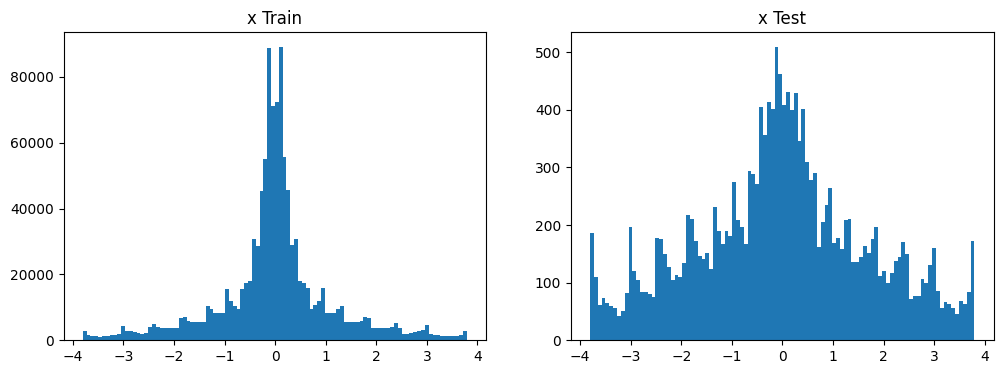

array([[-3.56595814e-01, -4.35485765e-02, -1.42610800e+00, ...,
        -5.72336853e-01,  2.11675367e+17,  1.01000000e+03],
       [-2.07623228e-01, -3.76319699e-02, -1.42610800e+00, ...,
        -5.63614786e-01,  6.89056172e+17,  1.01000000e+03],
       [-2.19147384e-01,  9.03529115e-03, -1.42610800e+00, ...,
        -5.53628623e-01,  7.29583346e+17,  1.01000000e+03],
       ...,
       [-3.22722387e+00,  5.89895695e-02,  2.78641963e+00, ...,
        -2.64337689e-01,  6.12491542e+17,  1.01900000e+03],
       [-3.37502265e+00,  1.63685516e-01,  2.78641963e+00, ...,
        -2.64337689e-01,  0.00000000e+00,  1.01900000e+03],
       [-3.45573568e+00,  1.08612336e-01,  2.78641963e+00, ...,
        -2.64337689e-01,  0.00000000e+00,  1.01900000e+03]], dtype=float32)

In [5]:
train_mean = train_bh.Xmean
train_std = train_bh.Xstd

train_bh.feature_scaling(train_mean, train_std)
test_bh.feature_scaling(train_mean, train_std)

# draw histogram of the 1st feature of the training and test set

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(train_bh.dataset[:, 0], bins=100)
axs[0].set_title(f'x Train')
axs[1].hist(test_bh.dataset[:, 0], bins=100)
axs[1].set_title(f'x Test')
plt.show()

train_bh.dataset


## First model: logistic regression

Let's first evaluate the performance of a linear model, as a baseline, in order to compare other models performance. The first value used for performance evaluation is the accuracy. This will not be the final metrics, since the real challenge is to evaluate full tracks, not single points.

In [6]:
model = LogisticRegression()
model.fit(train_bh.X, train_bh.y)

LogisticRegression()

In [7]:
# training set accuracy
train_y_pred = model.predict(train_bh.X)
print('Train accuracy: ', accuracy_score(train_bh.y, train_y_pred))

# test set accuracy
skip = True
if not skip:
    test_y_pred = model.predict(test_bh.X)
    print('Test accuracy: ', accuracy_score(test_bh.y, test_y_pred))

Train accuracy:  0.7459359469504342


## Second model: Fully Connected NN

Let's evaluate the performance of a simple fully connected NN (approach of the 2nd place solution on the kaggle competition)

In [8]:
#check for gpu
if torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   print ("MPS device not found.")

use_cpu = True
if use_cpu:
    device = torch.device("cpu")

x = torch.ones(1, device=device)
print(x)

tensor([1.])


In [9]:
INPUT_SIZE = 10
fc_model = FullyConnectedClassifier(INPUT_SIZE, sigmoid_output=False).to(device)
if device.type == "cpu": 
    fc_model = torch.compile(fc_model, mode = "max-autotune-no-cudagraphs", dynamic=True)
#else: 
#    fc_model = torch.compile(fc_model)

loss_function = nn.BCEWithLogitsLoss()  # sigmoid + Binary Cross Entropy 
LEARNING_RATE = 0.01
optimizer = torch.optim.Adam(fc_model.parameters(), lr=LEARNING_RATE)

In [10]:
train_loader = torch.utils.data.DataLoader(train_bh, batch_size=64, shuffle=True, drop_last=True,
                                           pin_memory=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_bh, batch_size=64, shuffle=False, drop_last=True,
                                            pin_memory=True, num_workers=4)

In [11]:
# create necessary function to train and evaluate the model

def train(model, train_loader, loss_function, optimizer, device, accumulation_steps=1):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    for ibatch, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch).squeeze()
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        if (ibatch + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_loss(model, data_loader, loss_function, device):
    model.eval()
    raise NotImplementedError
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()
            total_loss += loss_function(y_pred, y_batch).item()
    return total_loss / len(data_loader)

def evaluate_accuracy(model, data_loader, device, threshold):
    '''
        Evaluate the accuracy of the model on the data_loader.
        A sigmoid is applied to the output of the model to get the prediction.
    '''
    model.sigmoid_output = True
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()
            y_pred = (y_pred.detach() > threshold).float()
            correct += (y_pred == y_batch).sum()
            total += len(y_batch)
    model.sigmoid_output = False
    return correct / total

In [12]:
# train the model

EPOCHS = 20
train_losses = []
train_accuracies = []
test_accuracies = []
train_bool = False
model_path = '../../models/fc_model_state_dict.pth'
accumulation_steps = 4

if train_bool:
    for epoch in tqdm(range(EPOCHS)):

        # Train
        train_loss = train(fc_model, train_loader, loss_function, optimizer, device, accumulation_steps)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f'\t- train loss: {train_loss:.4f}')

        # Evaluate
        if (epoch) % 4 == 0:
            train_accuracy = evaluate_accuracy(fc_model, train_loader, device)
            test_accuracy = evaluate_accuracy(fc_model, test_loader, device)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            print(f'\t- train accuracy: {train_accuracy:.4f}')
            print(f'\t- test accuracy: {test_accuracy:.4f}')
    torch.save(fc_model.state_dict(), model_path)


Visualize training loss and train, test accuracy over different epochs 

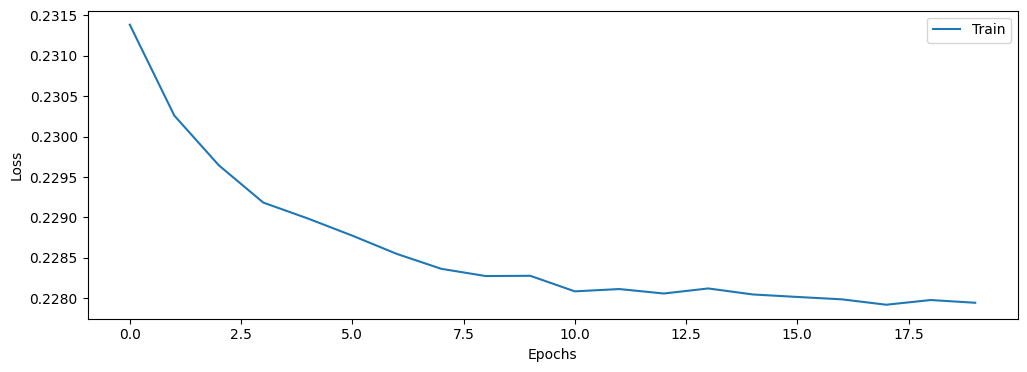

In [20]:
epochs = [iepoch for iepoch in range(EPOCHS)]

plt.figure(figsize=(12, 4))
plt.plot(epochs, train_losses, label = "Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")


plt.legend()

plt.show()

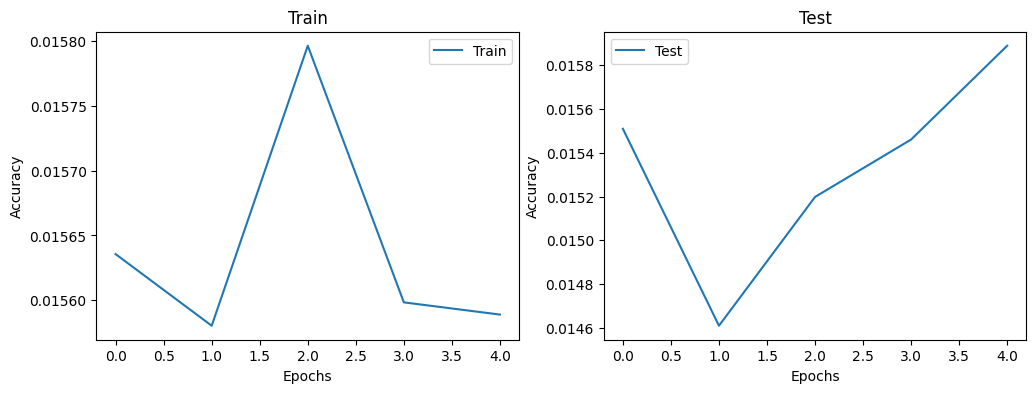

In [22]:
epochs = [iepoch for iepoch in range(EPOCHS//4)]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(epochs, train_accuracies, label = "Train")
axs[0].set_title(f'Train')
axs[1].plot(epochs, test_accuracies, label = "Test")
axs[1].set_title(f'Test')
for ax in axs:
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
plt.show()

In [13]:
# evaluate the model

fc_model.load_state_dict(torch.load(model_path))

# training set accuracy
train_acc = evaluate_accuracy(fc_model, train_loader, device, 0.85)
print('Train accuracy: ', train_acc)

# test set accuracy
if not skip:
    test_acc = evaluate_accuracy(fc_model, test_loader, device, 0.85)
    print('Test accuracy: ', test_acc)

Train accuracy:  tensor(0.9684)


In [14]:
# reconstruct tracks (train set)
skip = True
if not skip:
    tr_train = TrackReconstruction(train_bh, fc_model, device)
    tr_train.compute_prediction_matrix(minimum_threshold=0.5, output_file='../../data/save/train_prediction_matrix.npy')
    tr_train.reconstruct_all_tracks(threshold=0.85, output_file='../../data/save/train_all_tracks.npy')
    tr_train.score_tracks()
    tr_train.select_tracks()
    tr_train.evaluate_tracking()

# reconstruct tracks (test set)

tr_test = TrackReconstruction(test_bh, fc_model, device)
tr_test.compute_prediction_matrix(minimum_threshold=0.5, output_file='../../data/save/test_prediction_matrix.npy')
tr_test.reconstruct_all_tracks(threshold=0.85, output_file='../../data/save/test_all_tracks.npy')
tr_test.score_tracks()
tr_test.select_tracks()
tr_test.evaluate_tracking()

Computing prediction matrix...


  0%|          | 0/17709 [00:00<?, ?it/s]